In [1]:
import imaging_behavior_functions
#import odor_behavioral_analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.io
import os
import mat73
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from scipy.stats import iqr
from PIL import Image
import cv2
from IPython.display import display, clear_output
import time
import seaborn as sns
from scipy.stats import iqr
from scipy.ndimage import gaussian_filter1d
import glob
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import plotly.graph_objects as go
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import tensorflow as tf
from torchsummary import summary
from scipy.stats import sem
import random
import json
from scipy.integrate import quad
from scipy.stats import gaussian_kde
from sklearn.cluster import DBSCAN

In [3]:
base_path = "//research.files.med.harvard.edu/neurobio/wilsonlab/Jingxuan/processed/MBON_imaging/MBON09/"
example_path_data = base_path+"20230728-4_MBON09_GCAMP7f_patchy_strip_fly2/data/"
example_path_results = base_path+"20230728-4_MBON09_GCAMP7f_patchy_strip_fly2/results/"
trial_num = 1
odor_threshold = 5
time_interval_threshold = 16  # Assuming time is in seconds or an equivalent unit
k = 8
window_size = 30

is_mat73, roi_df, dff_raw, kinematics_raw, preprocessed_vars_ds, preprocessed_vars_odor = imaging_behavior_functions.load_intermediate_mat(example_path_data,trial_num)
behav_df = imaging_behavior_functions.make_df_behavior(dff_raw, preprocessed_vars_ds, preprocessed_vars_odor,trial_num,ball_d = 9)
xPos, yPos = imaging_behavior_functions.reconstruct_path(behav_df, ball_d = 9)
roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence = imaging_behavior_functions.get_roi_seq(roi_df)
dff_all_rois, dff_time = imaging_behavior_functions.load_dff_raw(is_mat73, dff_raw)
neural_df = imaging_behavior_functions.make_df_neural(dff_all_rois, dff_time, roi_names, hdeltab_index, epg_index, fr1_index, hdeltab_sequence, epg_sequence, fr1_sequence)
#behav_df, padded_result_df, smoothed_df = odor_behavioral_analysis.analysis_dfs(behav_df, time_interval_threshold, k, window_size)
combined_df = imaging_behavior_functions.combine_df(behav_df, neural_df)
#smoothed_df["translationalV_smoothed"] = np.sqrt(smoothed_df["fwV_smoothed"]**2+smoothed_df["sideV_smoothed"]**2)

In [4]:
behav_df = imaging_behavior_functions.calculate_theta_g_rho(behav_df,window_size=700)
behav_df = imaging_behavior_functions.segment_path(behav_df,rho_threshold=0.3,min_duration_below_rho=80.0)

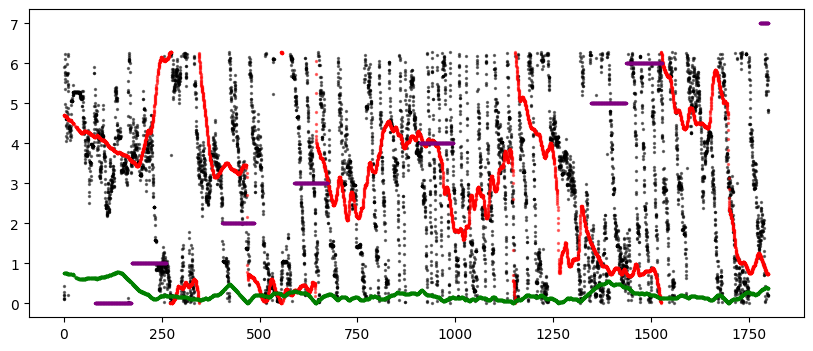

In [5]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.scatter(behav_df['time'], behav_df['heading'],s=2,color='black',alpha=0.5,label='heading')
ax.scatter(behav_df['time'], behav_df['theta_g'],s=2,color='red',alpha=0.5,label='goal')
ax.scatter(behav_df['time'], behav_df['rho_t'],s=2,color='green',alpha=0.5,label='straightness')
ax.scatter(behav_df['time'], behav_df['segment'],s=2,color='purple',alpha=0.5,label='segment')


In [6]:
len(behav_df['time'])

7485

Test circulr clustering

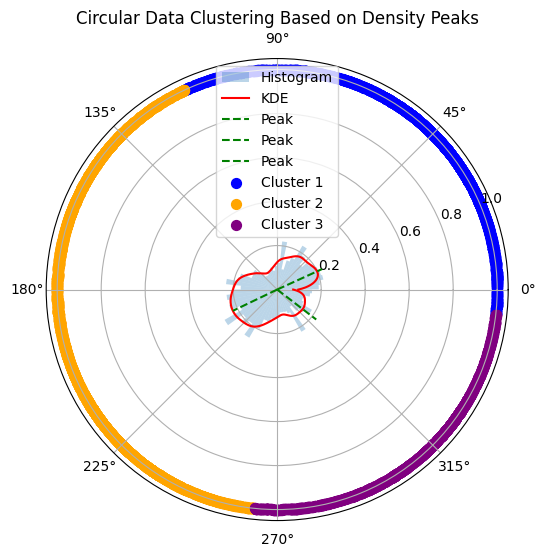

In [7]:
def circular_kde(theta, bandwidth=0.1):
    """
    Perform Kernel Density Estimation (KDE) on circular data.
    
    Parameters:
    - theta: array of angular data (in radians).
    - bandwidth: bandwidth for the KDE kernel (default is 0.1).
    
    Returns:
    - kde_values: KDE estimated values.
    - theta_grid: Corresponding angles (in radians).
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)
    kde = gaussian_kde(theta, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

def find_density_peaks(kde_values, theta_grid, threshold=0.5):
    """
    Find peaks in the KDE distribution to identify clusters.
    
    Parameters:
    - kde_values: KDE values from the circular KDE.
    - theta_grid: Corresponding angular values (in radians).
    - threshold: Minimum KDE value to consider as a peak.
    
    Returns:
    - peak_angles: Angles (in radians) of the detected density peaks.
    """
    peaks = np.where((kde_values[1:-1] > kde_values[:-2]) & (kde_values[1:-1] > kde_values[2:]))[0] + 1
    peak_angles = theta_grid[peaks][kde_values[peaks] > threshold]
    return peak_angles

def assign_clusters(theta, peak_angles):
    """
    Assign data points to clusters based on proximity to density peaks.
    
    Parameters:
    - theta: array of angular data (in radians).
    - peak_angles: Angles (in radians) of the density peaks.
    
    Returns:
    - cluster_labels: Array of cluster labels assigned to each data point.
    - cluster_peak_angles: Array of peak angles corresponding to each data point's assigned cluster.
    """
    # Compute distances to each peak angle
    distances = [np.abs(np.angle(np.exp(1j * (theta - peak)))) for peak in peak_angles]
    
    # Assign each point to the closest peak (minimum distance)
    cluster_labels = np.argmin(distances, axis=0)
    cluster_peak_angles = peak_angles[cluster_labels]
    
    return cluster_labels, cluster_peak_angles


# Circular KDE
kde_values, theta_grid = circular_kde(behav_df['heading'])

# Find peaks in the density distribution
peak_angles = find_density_peaks(kde_values, theta_grid, threshold=0.05)

# Assign clusters and get peak angle for each entry
cluster_labels, cluster_peak_angles = assign_clusters(behav_df['heading'].values, peak_angles)

# Add the cluster label and the corresponding cluster peak angle back to the DataFrame
behav_df['cluster_label'] = cluster_labels
behav_df['cluster_peak_angle'] = cluster_peak_angles

# Plot the clustering results for visualization
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(6, 6))
ax.hist(behav_df['heading'], bins=60, density=True, alpha=0.3, label="Histogram")
ax.plot(theta_grid, kde_values, label="KDE", color="red")

# Mark the peaks
for peak in peak_angles:
    ax.plot([peak, peak], [0, max(kde_values)], color='green', linestyle="--", label="Peak")

# Assign colors to the clusters and plotting
colors = ['blue', 'orange', 'purple']
for cluster in np.unique(behav_df['cluster_label']):
    cluster_data = behav_df[behav_df['cluster_label'] == cluster]['heading']
    ax.scatter(cluster_data, np.ones_like(cluster_data), label=f'Cluster {cluster+1}', s=50, color=colors[cluster])

ax.set_title("Circular Data Clustering Based on Density Peaks")
ax.legend()
plt.show()


Text(0.5, 1.0, 'Fly Trajectory')

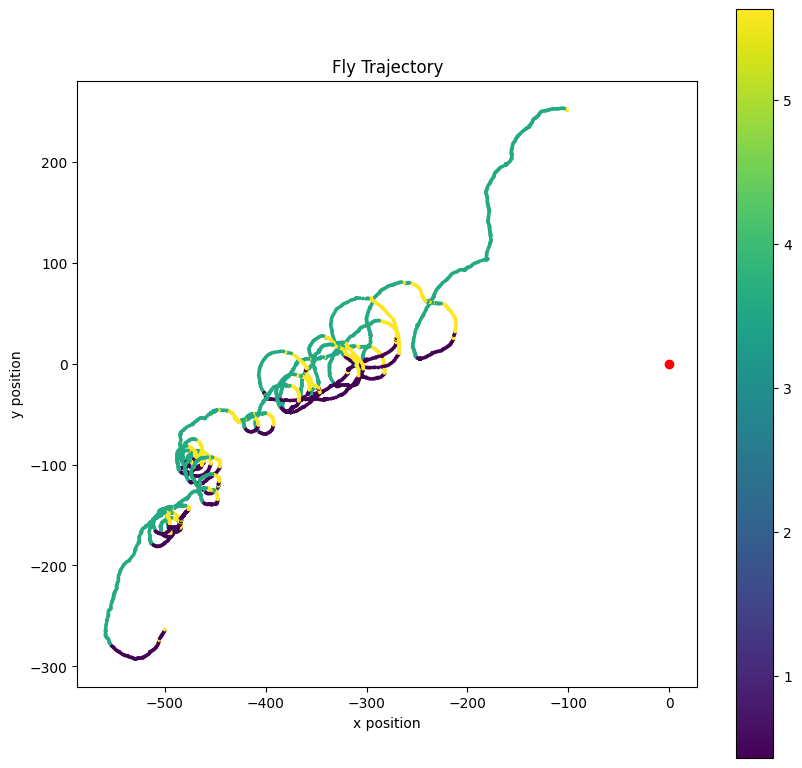

In [36]:
label = 'cluster_peak_angle'
query_idx1 = 1400
query_idx2 = 5500
x_range = max(xPos) - min(xPos)
y_range = max(yPos) - min(yPos)
aspect_ratio = y_range / x_range

# Set figure dimensions based on data range while keeping unit scale the same
fig_width = 10  # Width of figure in inches
fig_height = fig_width * aspect_ratio  # Height is scaled according to the aspect ratio of the data

plt.figure(figsize=(fig_width, fig_height))

if label in behav_df.columns:
    # If the label exists, color the scatter plot based on the label values
    plt.scatter(xPos[query_idx1:query_idx2], yPos[query_idx1:query_idx2], c=behav_df[label][query_idx1:query_idx2], s=3)
    plt.colorbar()  # Optionally, add a color bar to indicate the mapping of color to label values
else:
    # If the label does not exist, plot a normal scatter plot without coloring
    plt.scatter(xPos, yPos, s=3)
    label = "nothing"
plt.scatter(0, 0, color='red')  # Mark the origin

# Enforce equal aspect ratio so that one unit in x is the same as one unit in y
plt.gca().set_aspect('equal', adjustable='box')

plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Fly Trajectory')

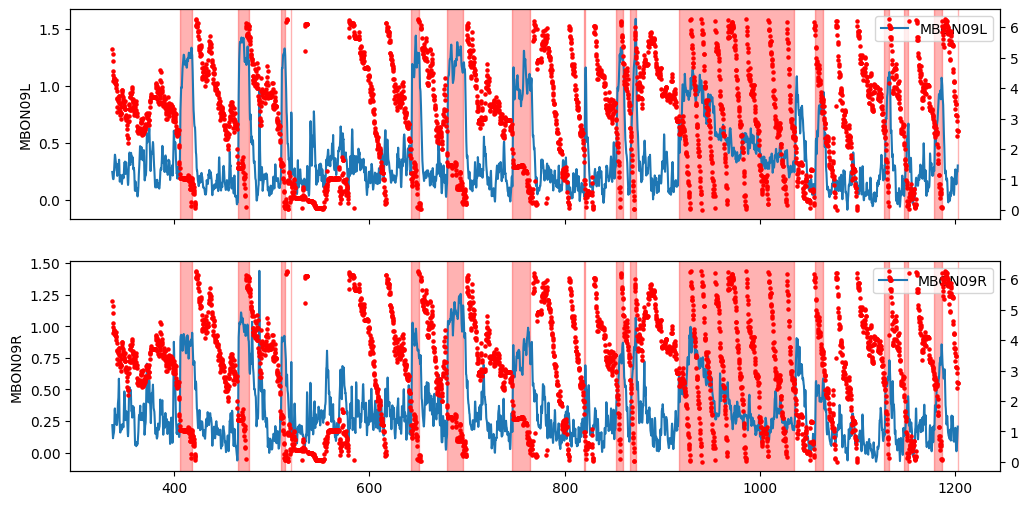

In [9]:
neural_columns = len(neural_df.columns.drop('time'))
behav_columns = len(['fwV', 'yawV', 'sideV', 'heading'])
total_plots = neural_columns #+ behav_columns

# Create a figure with subplots
fig, axs = plt.subplots(total_plots, 1, figsize=(12, 3 * total_plots), sharex=True)

# Plot each column from neural_df as a subplot
for i, column in enumerate(neural_df.columns.drop('time')):
    axs[i].plot(neural_df['time'][query_idx1:query_idx2], neural_df[column][query_idx1:query_idx2], label=column)
    axs[i].set_ylabel(column)
    axs[i].legend(loc='upper right')
    axs2 = axs[i].twinx()
    axs2.scatter(behav_df['time'][query_idx1:query_idx2], behav_df['heading'][query_idx1:query_idx2],s=5,label='heading',color = 'red')

# Plot specified columns from behav_df as subplots
'''behav_columns = ['fwV', 'yawV', 'sideV', 'heading']
for j, column in enumerate(behav_columns, start=neural_columns):
    if column in behav_df.columns:
        axs[j].plot(behav_df['time'], behav_df[column], label=column, linestyle='--')
        axs[j].set_ylabel(column)
        axs[j].legend(loc='upper right')'''

# Check if 'odor' column exists and shade where odor > 5
if 'odor' in behav_df.columns:
    odor_mask = behav_df['odor'][query_idx1:query_idx2] > 5
    # Apply shading to all subplots
    for ax in axs:
        ax.fill_between(behav_df['time'][query_idx1:query_idx2], ax.get_ylim()[0], ax.get_ylim()[1], where=odor_mask, color='red', alpha=0.3, transform=ax.get_xaxis_transform())


In [29]:
unique_mode_headings = behav_df['cluster_peak_angle'].unique()

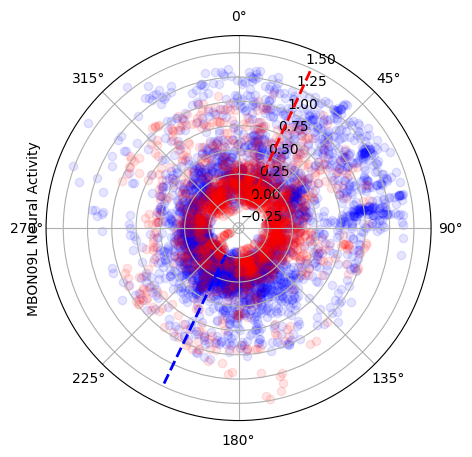

In [40]:
fig, ax = plt.subplots(figsize=(5,5), subplot_kw={'projection': 'polar'})  # Set the projection to polar
# Convert 'heading' to radians, assuming it's in degrees
#ax.scatter(behav_df['heading'], neural_df['MBON09L'], c=behav_df['odor'], cmap='viridis')
ax.scatter(behav_df['heading'][1400:5500], neural_df['MBON09L'][1400:5500], color = 'blue', alpha=0.1)
ax.scatter(behav_df['heading'][5500:8000], neural_df['MBON09L'][5500:8000], color = 'red', alpha=0.1)
ax.set_theta_zero_location('N')  # Optional: Set 0 degrees (north) at the top
ax.set_theta_direction(-1)  # Optional: Set the angular direction clockwise

# Optional: Label the colorbar for clarity
#cbar = plt.colorbar(ax.collections[0], ax=ax)
#cbar.set_label('Odor')

# Set labels for neural data
ax.set_ylabel("MBON09L Neural Activity")
# Add a radial line at a specific radian (for example, at pi/4 radians)
mode_hd = unique_mode_headings[1]
ax.plot([mode_hd, mode_hd], [0, 1.5], color='red', linewidth=2, linestyle='--')
mode_hd2 = unique_mode_headings[2]
ax.plot([mode_hd2, mode_hd2], [0, 1.5], color='blue', linewidth=2, linestyle='--')
plt.show()


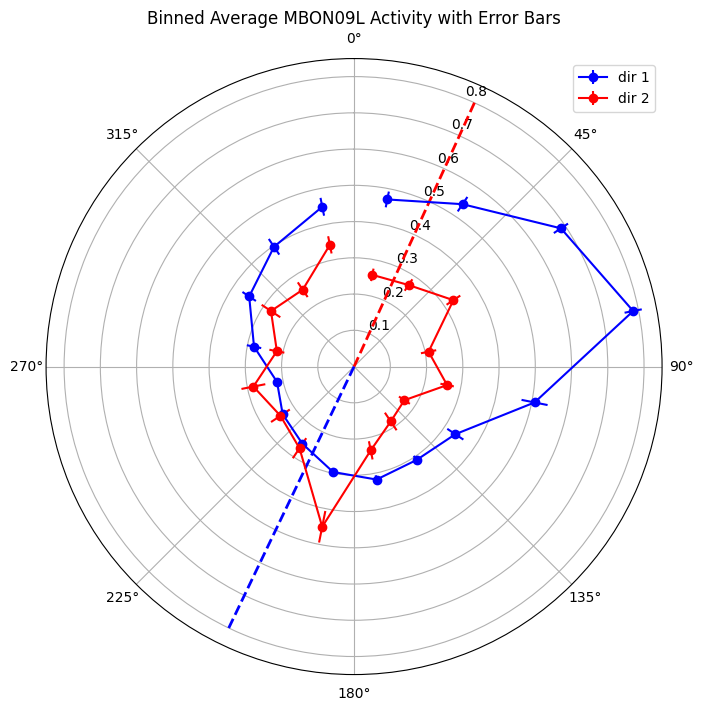

In [43]:
def binned_stats(headings, values, bins):
    """
    Calculate binned averages and standard errors.
    
    Parameters:
    - headings: array of angular data (in radians).
    - values: corresponding values (e.g., MBON09L) to be averaged.
    - bins: number of bins or a list of bin edges for angular data.
    
    Returns:
    - bin_centers: array of bin centers (in radians).
    - bin_means: array of mean values for each bin.
    - bin_errors: array of standard errors for each bin.
    """
    # Bin the heading data
    binned, bin_edges = pd.cut(headings, bins=bins, labels=False, retbins=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Calculate mean and standard error for MBON09L activity in each bin
    bin_means = []
    bin_errors = []
    for i in range(len(bin_edges) - 1):
        bin_values = values[binned == i]
        bin_means.append(np.mean(bin_values))
        bin_errors.append(np.std(bin_values) / np.sqrt(len(bin_values)))  # Standard error

    return bin_centers, np.array(bin_means), np.array(bin_errors)

# Convert heading to radians and filter data
#behav_df['heading_rad'] = np.deg2rad(behav_df['heading'])
#with_odor = behav_df['odor'] >5
#without_odor = behav_df['odor'] <=5

# Define bins for the circular data (e.g., 12 bins)
bins = np.linspace(0, 2 * np.pi, 17)

# Calculate binned statistics for both conditions
centers_with, means_with, errors_with = binned_stats(behav_df['heading'][1400:5500], neural_df['MBON09L'][1400:5500], bins)
centers_without, means_without, errors_without = binned_stats(behav_df['heading'][5500:8000], neural_df['MBON09L'][5500:8000], bins)

# Plotting on polar coordinates
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
ax.errorbar(centers_with, means_with, yerr=errors_with, fmt='o-', label='dir 1', color='blue')
ax.errorbar(centers_without, means_without, yerr=errors_without, fmt='o-', label='dir 2', color='red')

# Additional plot settings
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)
ax.set_title('Binned Average MBON09L Activity with Error Bars')
ax.legend()

# Add a radial line at a specific radian (for example, at pi/4 radians)
mode_hd = unique_mode_headings[1]
ax.plot([mode_hd, mode_hd], [0, 0.8], color='red', linewidth=2, linestyle='--')
mode_hd2 = unique_mode_headings[2]
ax.plot([mode_hd2, mode_hd2], [0, 0.8], color='blue', linewidth=2, linestyle='--')

plt.show()


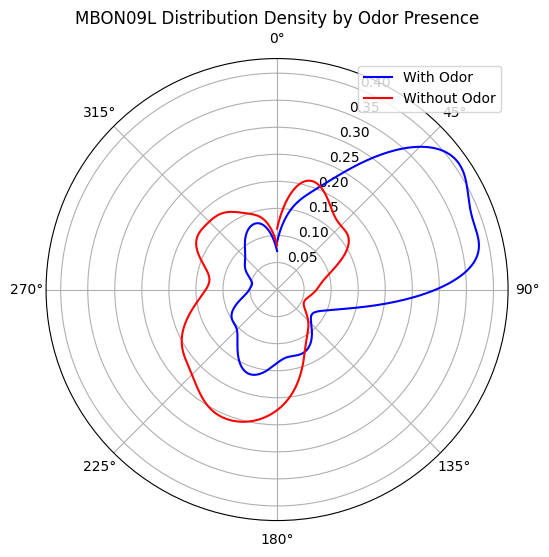

In [37]:
def circular_kde(data, headings, bandwidth=0.1):
    """
    Perform KDE on circular data (MBON09L values) with respect to the heading (in radians).
    
    Parameters:
    - data: The data values (e.g., MBON09L) for which we want to compute density.
    - headings: Circular variable (heading in radians) as the angular support.
    - bandwidth: Bandwidth for KDE.
    
    Returns:
    - kde_values: KDE estimated values.
    - theta_grid: Corresponding angular grid points (in radians).
    """
    theta_grid = np.linspace(0, 2 * np.pi, 500)  # 0 to 2*pi for the circular support
    kde = gaussian_kde(headings, weights=data, bw_method=bandwidth)
    kde_values = kde(theta_grid)
    
    return kde_values, theta_grid

with_odor = behav_df['odor'] > 5
without_odor = behav_df['odor'] <= 5

# Perform circular KDE for MBON09L distribution for both conditions
kde_with_odor, theta_grid = circular_kde(neural_df['MBON09L'][with_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][with_odor & (neural_df['MBON09L'] >= 0)])
kde_without_odor, _ = circular_kde(neural_df['MBON09L'][without_odor & (neural_df['MBON09L'] >= 0)], behav_df['heading'][without_odor & (neural_df['MBON09L'] >= 0)])

# Plot the KDE results on the polar coordinate system
fig, ax = plt.subplots(figsize=(6,6), subplot_kw={'projection': 'polar'})

# Plot KDE curve for with odor
ax.plot(theta_grid, kde_with_odor, label='With Odor', color='blue')

# Plot KDE curve for without odor
ax.plot(theta_grid, kde_without_odor, label='Without Odor', color='red')

# Add titles, legend, and labels
ax.set_title("MBON09L Distribution Density by Odor Presence")
ax.set_theta_zero_location('N')  # Set 0 degrees (north) at the top
ax.set_theta_direction(-1)       # Set the angular direction clockwise

# Add legend
ax.legend(loc="upper right")

plt.show()


In [35]:
np.where(neural_df['MBON09L'][with_odor]<0)

(array([1433, 1434, 1703, 1704, 1705, 1706], dtype=int64),)

### EPG processing 

In [5]:
epg_df = neural_df.filter(like='EPG')
epg_df

,EPG_0,EPG_1,EPG_2,EPG_3,EPG_4,EPG_5,EPG_6,EPG_7,EPG_8,EPG_9,...,EPG_20,EPG_21,EPG_22,EPG_23,EPG_24,EPG_25,EPG_26,EPG_27,EPG_28,EPG_29
0,2.723054,0.892353,1.214028,1.743374,2.166797,2.234061,3.058426,2.674723,2.845853,3.090423,...,1.778661,2.459945,2.474280,1.743127,1.903536,1.877679,1.714433,1.692436,1.355308,0.981021
1,2.864456,1.103269,1.143212,1.687360,2.074136,2.198340,2.757989,2.533699,2.644873,2.942089,...,1.762801,2.308727,2.410312,1.729007,2.047879,2.164652,2.136542,2.246190,1.914916,1.590011
2,3.738657,1.476766,1.308932,1.620242,1.944892,1.964879,2.320715,2.172650,2.277311,2.658761,...,1.508232,1.955571,2.123074,1.511344,2.087945,2.317293,2.457225,2.679639,2.448921,2.207648
3,4.636425,1.782339,1.477424,1.501613,1.705614,1.653203,1.928812,1.738895,1.871738,2.263781,...,1.190439,1.606212,1.756443,1.225380,2.056184,2.322880,2.607774,2.879525,2.760156,2.509236
4,5.248745,1.893037,1.570783,1.434932,1.479327,1.433266,1.633765,1.391593,1.505390,1.903914,...,0.993123,1.353303,1.454187,1.032984,1.954573,2.272118,2.633817,2.989960,2.861271,2.608892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,2.729314,2.416504,1.905878,0.930155,1.025140,0.267064,0.170871,0.304852,0.255301,0.627908,...,0.278155,0.177689,0.436523,0.415495,1.040792,1.464250,2.470433,2.659594,3.026334,3.505047
2053,2.701487,2.401290,1.726724,0.879139,0.960849,0.369732,0.223090,0.288241,0.201353,0.550387,...,0.228247,0.212573,0.398730,0.419965,0.991494,1.491411,2.483958,2.652767,2.948268,3.443189
2054,2.074075,2.155816,1.477726,0.893341,0.900961,0.448354,0.260100,0.230421,0.219046,0.573498,...,0.218835,0.232854,0.484072,0.461322,0.991760,1.543880,2.520692,2.705019,2.880502,3.289761
2055,1.723742,1.951129,1.303298,0.988706,0.984354,0.465009,0.250617,0.194844,0.260288,0.614825,...,0.259136,0.219845,0.604700,0.505460,1.009610,1.518933,2.422403,2.714442,2.869919,3.184348


<Axes: >

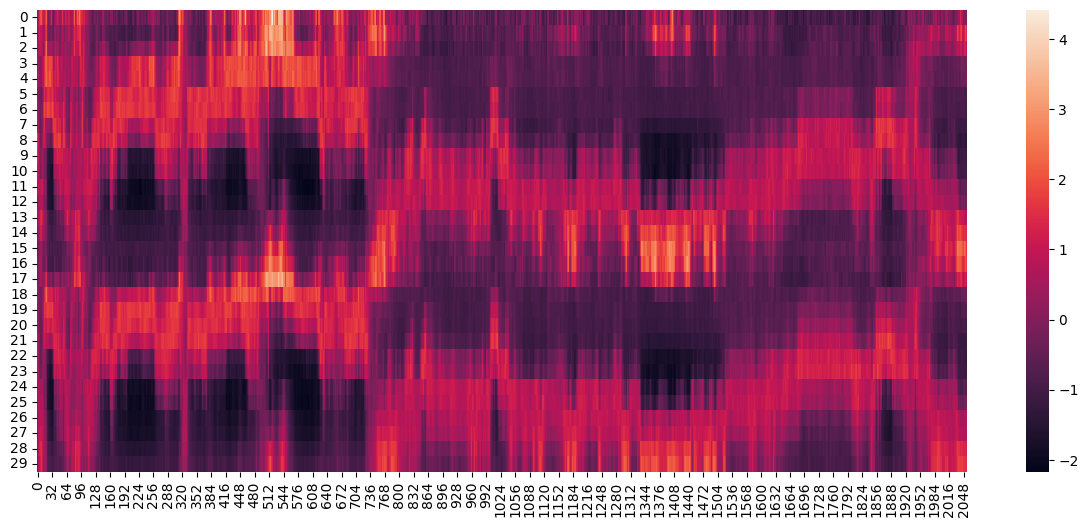

In [6]:
scaler = StandardScaler()
roi_mtx_ori =  epg_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [7]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_epg(np.transpose(roi_mtx))

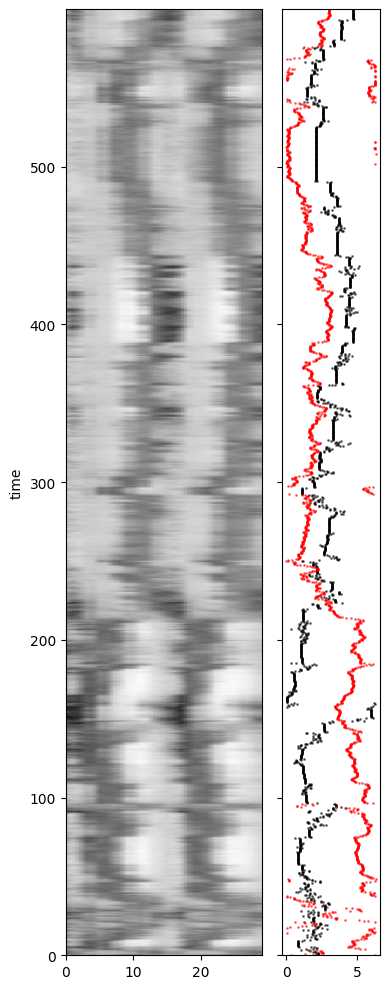

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()



In [21]:
# calculate offset
phase_dif_epg = np.angle(np.exp(1j*behav_df.heading[ind1:ind2])/np.exp(1j*(pva_phase[ind1:ind2]+np.pi))) 
phase_dif_epg

array([1.7138969 , 1.94166096, 1.7783599 , ..., 1.86761494, 1.86154615,
       1.88850513])

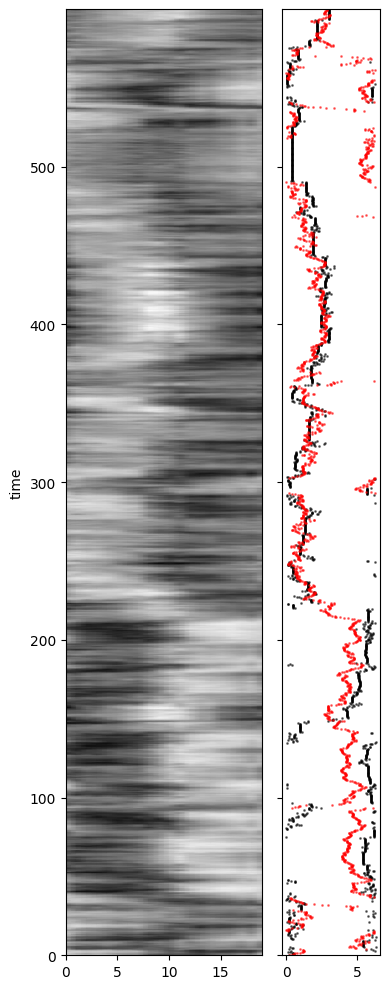

In [33]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [2, 1]})
ind1 = 0
ind2 = len(epg_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
hd_zerooff = behav_df.heading-phase_dif_epg[0]
hd_zerooff[hd_zerooff<0] += 2*np.pi
ax2.scatter(hd_zerooff, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')
#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('epg.pdf', format='pdf', bbox_inches='tight')


Text(0, 0.5, 'heading')

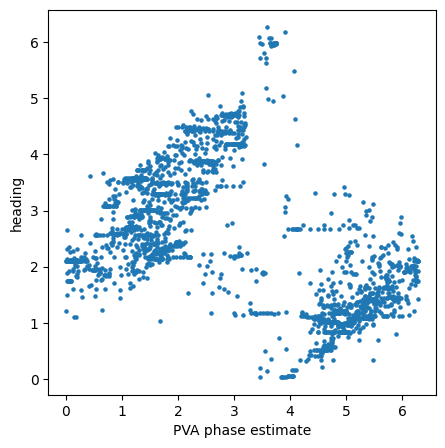

In [10]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(pva_phase+np.pi, behav_df.heading, marker = 'o',s=5)
ax.set_xlabel('PVA phase estimate')
ax.set_ylabel('heading')

In [11]:

# Columns to smooth
cols_to_smooth = ['fwV','sideV','yawV']
sigma = 8
def smooth_columns(df, cols_to_smooth,sigma):
    # Create a new DataFrame with smoothed columns
    smoothed_df = pd.DataFrame()

    for col in df.columns:
        if col in cols_to_smooth:
            smoothed_data = gaussian_filter1d(df[col].values, sigma=sigma, mode='nearest')
            smoothed_df[col] = smoothed_data
        else:
            smoothed_df[col] = df[col]
    return smoothed_df

smoothed_df = smooth_columns(behav_df, cols_to_smooth,sigma)

In [12]:
smoothed_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628


In [13]:
def calculate_translational_velocity_df(df):
    """
    Calculate translational velocities and directions for multiple time points provided in a DataFrame.

    Parameters:
        df (pandas.DataFrame): DataFrame containing columns 'fwV' for forward velocity (mm/s) 
                               and 'sideV' for side velocity (rad/s).
        radius (float): Radius of the ball in mm.
        heading_direction_rad (float): Instantaneous heading direction of the animal in radians (assumed constant for simplicity).

    Returns:
        pandas.DataFrame: DataFrame with additional columns 'translational_velocity_mm_s' and 'translational_direction_rad'.
    """
    # Convert side velocity from rad/s to mm/s
    #df['side_velocity_mm'] = df['sideV'] * radius

    # Calculate the magnitude of the translational velocity
    df['translational_velocity_mm_s'] = np.sqrt(df['sideV']**2 + df['fwV']**2)

    # Calculate the direction of the translational velocity
    df['translational_direction_rad'] = (df['heading'] + np.arctan2(df['sideV'], df['fwV'])) % (2*np.pi)


    return df

radius = 4.5 
result_df = calculate_translational_velocity_df(smoothed_df)
result_df

,time,fwV,sideV,yawV,heading,abssideV,absyawV,net_motion,net_motion_state,heading_adj,odor,xPos,yPos,translational_velocity_mm_s,translational_direction_rad
0,0.000000,2.123724,-0.432361,-0.365113,1.909094,0.000000,0.000000,0.000000,0,1.909094,-0.000000,0.000000,0.000000,2.167289,1.708252
1,0.291806,2.438918,-0.509781,-0.409644,2.251022,2.601109,1.443248,5.483164,1,2.251022,-0.010547,0.194625,0.421125,2.491626,2.044969
2,0.583611,2.765627,-0.587406,-0.455153,2.222788,1.462957,0.027780,1.620589,1,2.222788,-0.011848,0.236184,0.472403,2.827320,2.013503
3,0.875417,3.096965,-0.661636,-0.501112,2.220486,1.073745,0.020996,1.172523,1,2.220486,-0.014612,0.207335,0.439565,3.166852,2.010010
4,1.167222,3.425018,-0.728759,-0.547022,2.221038,0.389426,0.013092,0.429046,1,2.221038,-0.012081,0.217654,0.451001,3.501691,2.011389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,598.784922,0.195282,0.376175,0.047876,4.709517,0.658852,0.022617,0.750958,1,10.992702,-0.189355,411.521830,960.690741,0.423842,5.801482
2053,599.076727,0.196734,0.412159,0.040330,4.710929,4.710858,0.050595,5.395737,1,10.994115,-0.183650,411.536975,960.418813,0.456705,5.836382
2054,599.368533,0.200856,0.433987,0.036021,4.717707,1.295829,0.019059,1.559361,1,11.000892,-0.178025,411.526640,960.512944,0.478213,5.855043
2055,599.660338,0.207034,0.444796,0.034267,4.711299,4.804269,0.103648,5.007310,1,10.994484,-0.184927,411.564481,960.639628,0.490618,5.846461


In [14]:
hdeltab_df = neural_df.filter(like='hDeltaB')
hdeltab_df

,hDeltaB_0,hDeltaB_1,hDeltaB_2,hDeltaB_3,hDeltaB_4,hDeltaB_5,hDeltaB_6,hDeltaB_7,hDeltaB_8,hDeltaB_9,hDeltaB_10,hDeltaB_11,hDeltaB_12,hDeltaB_13,hDeltaB_14,hDeltaB_15,hDeltaB_16,hDeltaB_17,hDeltaB_18,hDeltaB_19
0,-0.193967,-0.000457,0.073373,0.019750,0.177525,0.426502,0.683414,0.780667,0.944247,1.071649,0.917875,0.786426,0.894922,1.093610,0.843931,0.730944,0.588569,0.487070,0.504135,0.010910
1,-0.116115,0.059882,0.099784,0.043648,0.168415,0.392602,0.599247,0.678869,0.904270,0.980953,0.896351,0.754305,0.864112,1.139721,0.946442,0.766402,0.670169,0.577942,0.567977,0.090014
2,-0.030915,0.105457,0.150837,0.090545,0.181895,0.361443,0.485518,0.530761,0.842716,0.871166,0.844065,0.692316,0.844093,1.152871,1.004232,0.780436,0.759679,0.640261,0.609428,0.160382
3,0.018073,0.113260,0.210224,0.118139,0.203891,0.350504,0.422369,0.423375,0.751085,0.746232,0.790395,0.628125,0.839876,1.127049,1.019851,0.769844,0.817656,0.648546,0.649909,0.196785
4,0.018680,0.136706,0.251679,0.129589,0.265536,0.385921,0.406132,0.398921,0.657362,0.672613,0.750189,0.607239,0.815054,1.112682,1.016412,0.791079,0.845272,0.668738,0.705568,0.211975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2052,0.725296,0.559247,0.465383,0.465341,0.371303,0.290641,0.151348,0.145858,0.216029,0.138736,0.044434,0.019219,0.129350,0.344191,0.601073,0.639127,0.735293,0.937902,0.830761,1.025948
2053,0.754518,0.641993,0.499176,0.443159,0.405628,0.296574,0.181517,0.110212,0.193165,0.177968,0.057779,0.030147,0.093549,0.342221,0.590682,0.618950,0.708239,0.926642,0.801019,1.074110
2054,0.745142,0.678675,0.520800,0.448398,0.436572,0.294794,0.163118,0.100149,0.178068,0.160501,0.078860,0.037575,0.117841,0.342180,0.610917,0.593001,0.674209,0.886596,0.796549,1.153398
2055,0.754913,0.655963,0.506834,0.480879,0.418295,0.333264,0.129951,0.092716,0.158295,0.138725,0.086364,0.048558,0.171463,0.321312,0.619844,0.596116,0.632169,0.834929,0.764140,1.193808


<Axes: >

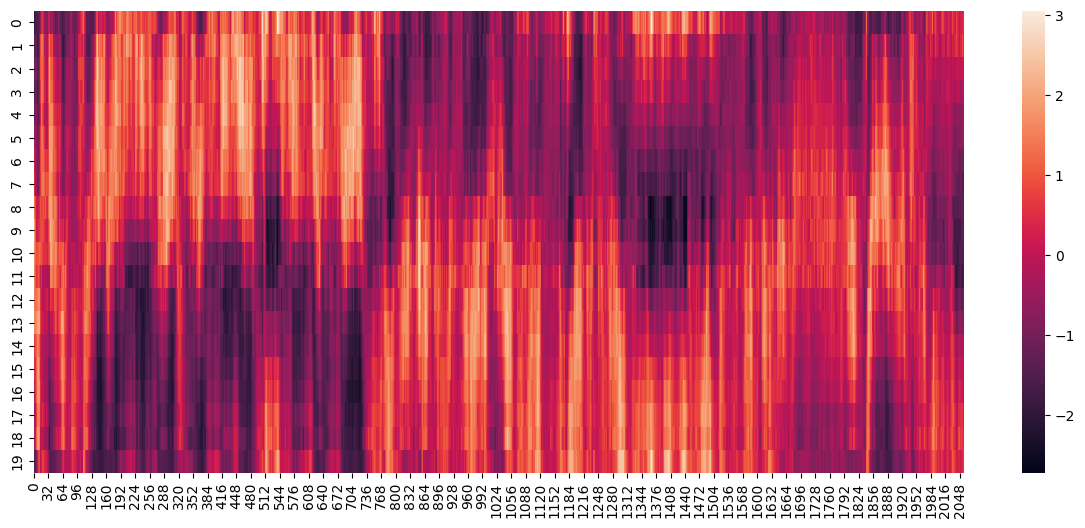

In [15]:
scaler = StandardScaler()
roi_mtx_ori =  hdeltab_df
roi_mtx = scaler.fit_transform(roi_mtx_ori)
plt.figure(figsize=(15, 6))
sns.heatmap(np.transpose(roi_mtx))

In [16]:
param_df = imaging_behavior_functions.fit_sinusoid(neural_df,roi_mtx)
param_df

,time,phase,baseline,amplitude,phase_error,baseline_error,amplitude_error
0,0.000000,3.637634,0.162491,1.751337,0.068677,0.083554,0.116011
1,0.291806,3.637634,0.173620,1.613633,0.069444,0.078162,0.108998
2,0.583611,3.637634,0.140976,1.446100,0.073902,0.074983,0.105208
3,0.875417,3.968328,0.077666,1.301645,0.083940,0.077088,0.108779
4,1.167222,3.968328,0.058063,1.197554,0.098021,0.083132,0.117748
...,...,...,...,...,...,...,...
2052,598.784922,5.952491,-0.498071,1.023527,0.067553,0.047858,0.066187
2053,599.076727,0.000000,-0.482666,1.043530,0.063070,0.045518,0.062895
2054,599.368533,0.000000,-0.475032,1.054903,0.056112,0.040930,0.056543
2055,599.660338,0.000000,-0.487071,1.035013,0.049882,0.035700,0.049321


In [17]:
pva_phase, pva_amplitude = imaging_behavior_functions.calculate_pva_hdeltab(np.transpose(roi_mtx))

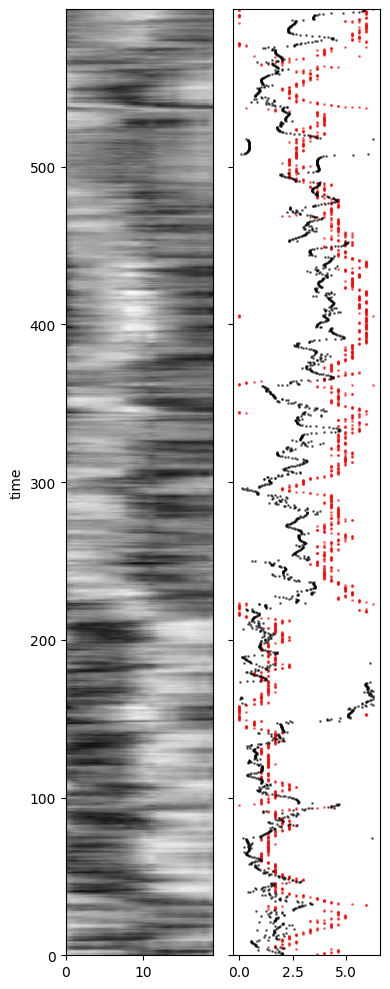

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
ax2.scatter(param_df.phase, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()

In [28]:
# calculate offset
phase_dif_hdeltab = np.angle(np.exp(1j*param_df.phase[ind1:ind2])/np.exp(1j*result_df.translational_direction_rad)) 
phase_dif_hdeltab

array([1.92938122, 1.59266462, 1.62413038, ..., 0.42814227, 0.43672413,
       0.44168583])

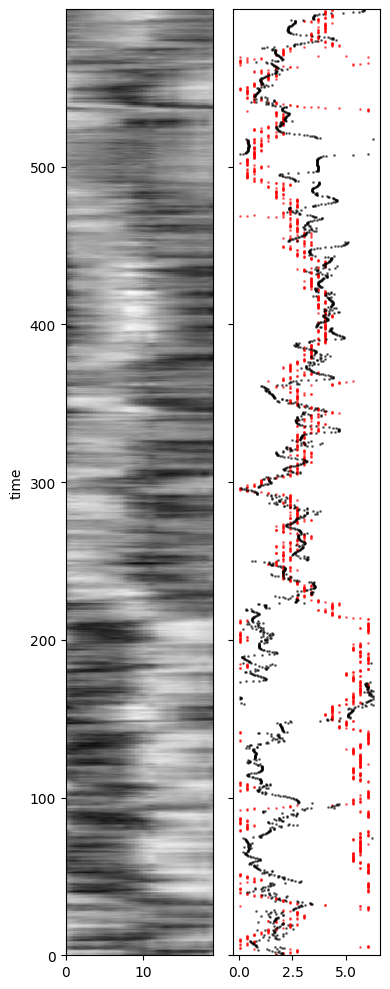

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(4, 10),gridspec_kw={'width_ratios': [1, 1]})
ind1 = 0
ind2 = len(hdeltab_df)

# Heatmap on ax1
c = ax1.pcolormesh(np.arange(np.transpose(roi_mtx).shape[0]), behav_df.time, roi_mtx, shading='gouraud',cmap='binary')
#fig.colorbar(c, ax=ax1)
ax1.set_ylabel('time')
#ax1.set_xlabel('PB phase')
# Scatter plot on ax2
phase_zerooff = param_df.phase-phase_dif_hdeltab[0]
phase_zerooff[phase_zerooff<0] += 2*np.pi
ax2.scatter(phase_zerooff, behav_df.time, s=1,color='red',alpha=0.5,label='heading')
ax2.scatter(result_df.translational_direction_rad, behav_df.time, s=1,color='black',alpha=0.5,label='translational direction')
#ax2.scatter(behav_df.heading, behav_df.time, s = 1,color='black',alpha=0.5,label='heading')
#ax2.scatter(pva_phase+np.pi, behav_df.time, s=1,color='red',alpha=0.5,label='PVA estimate')

#plt.legend()
#ax2.set_ylabel('heading')
#ax2.set_xlabel('heading')

plt.tight_layout()
plt.show()
fig.savefig('hdeltab.pdf', format='pdf', bbox_inches='tight')

Text(0, 0.5, 'phase')

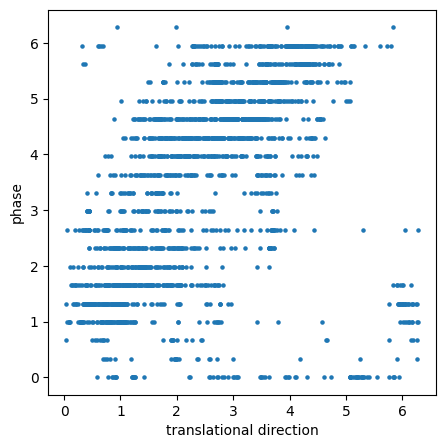

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_direction_rad, param_df.phase, marker = 'o',s=5)
#ax.scatter(behav_df.heading, pva_phase+np.pi, marker = 'o',color = 'red',s=5)
ax.set_xlabel('translational direction')
ax.set_ylabel('phase')

Text(0, 0.5, 'bump amplitude')

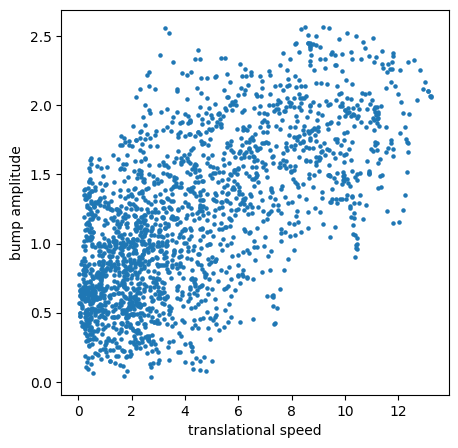

In [20]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(result_df.translational_velocity_mm_s, param_df.amplitude, marker = 'o',s=5)
ax.set_xlabel('translational speed')
ax.set_ylabel('bump amplitude')